#### Risk Analysis for CRC TCR Sequencing Bulk Data 
The following notebook contain the risk analysis for the CRC bulk dataset. It analysis the high and low risk patients using different analysis technique. The end of the the notebook contain the risk classification model. 

#### Set Environment

In [1]:
import collections
import pandas as pd
import numpy as np, interp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb

### Load data

In [2]:
CRC_embedding_data = pd.read_pickle('/home/ubuntu/CODON_CVC/CRC_blood/downsampled_data_with_all_labels_embeddings.pkl')


In [3]:
# put the cdr3_nt column as the last column
cdr3_nt = CRC_embedding_data['CDR3.nt']
cloneCount = CRC_embedding_data['cloneCount']
Proportion = CRC_embedding_data['Proportion']
v_gene = CRC_embedding_data['v_gene']
j_gene= CRC_embedding_data['j_gene']
aaSeqCDR3 = CRC_embedding_data['aaSeqCDR3']
Subject = CRC_embedding_data['Subject']
count = CRC_embedding_data['count']
public_private = CRC_embedding_data['Public_Private_label']
T = CRC_embedding_data['T']
N = CRC_embedding_data['N']
M = CRC_embedding_data['M']
chain = CRC_embedding_data['chain']
MAIT_cell = CRC_embedding_data['MAIT_cell']

CRC_embedding_data = CRC_embedding_data.drop(columns=['cloneCount', 'Proportion', 'CDR3.nt', 'V.name', 'J.name',
       'D.name', 'aaSeqCDR3', 'Subject', 'count', 'Public_Private_label',
       'v_gene', 'j_gene', 'T', 'N', 'M', 'chain', 'MAIT_cell'])
CRC_embedding_data['cloneCount'] = Proportion
CRC_embedding_data['Proportion'] = cloneCount
CRC_embedding_data['CDR3.nt'] = cdr3_nt
CRC_embedding_data['v_gene'] = v_gene
CRC_embedding_data['j_gene'] = j_gene
CRC_embedding_data['aaSeqCDR3'] = aaSeqCDR3
CRC_embedding_data['Subject'] = Subject
CRC_embedding_data['count'] = count
CRC_embedding_data['Public_Private_label'] = public_private
CRC_embedding_data['T'] = T
CRC_embedding_data['N'] = N
CRC_embedding_data['M'] = M
CRC_embedding_data['chain'] = chain
CRC_embedding_data['MAIT_cell'] = MAIT_cell
# add N_bianry column
CRC_embedding_data['N_binary'] = CRC_embedding_data['N'].apply(lambda x: 0 if x == 0 else 1)

#### Risk Labeling 
The risk (low=0, high=1) label is only applied to the patients who don't have metastasis (M=0).

In [5]:
CRC_embedding_data_M0 = CRC_embedding_data[CRC_embedding_data['M'] == 0]
# I want to add a column 'Risk' that is 1 of the patient has t=4 or n=2, 0 otherwise
CRC_embedding_data_M0['Risk'] = CRC_embedding_data_M0.apply(lambda x: 1 if x['T'] == 4 or x['N'] == 2 else 0, axis=1)
CRC_embedding_data_M0

/tmp/ipykernel_4985/1800154535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRC_embedding_data_M0['Risk'] = CRC_embedding_data_M0.apply(lambda x: 1 if x['T'] == 4 or x['N'] == 2 else 0, axis=1)


0         1         2         3         4         5         6  \
0        0.439937  0.398926  0.883038 -0.309778  0.687281 -0.018071 -0.026907   
1        0.064476 -0.535562 -0.229020 -0.559817 -0.309919 -0.457965  0.416588   
2        0.684437  0.358636  0.828198  0.857685  0.326658 -0.566441 -0.528951   
3        0.510045  0.095592  1.202585  0.192675  0.224053 -0.000038 -0.049890   
4        0.567597  0.923898  0.725318 -0.011695  0.438315 -0.436650 -0.131053   
...           ...       ...       ...       ...       ...       ...       ...   
1172036  0.296920 -0.532109  0.311326  0.335216 -0.195077 -0.254745 -0.050958   
1172037  0.971486  0.033927  0.999215 -0.003763  0.621668  0.236323  0.046829   
1172038  0.886601 -0.369868  0.124988  0.102641  0.043402 -0.358449  0.129088   
1172039  0.729134 -0.609653  0.265497  0.203764  0.421940 -0.091077  0.297067   
1172040  0.232383  0.137062  0.552330  0.359369 -0.571558 -0.413611  1.009362   

                7         8         9  ...   Subject  count  \
0       -0.709836  0.857734  0.049845  ...  pool1_S1      2   
1       -0.022723  0.415283 -0.613813  ...  pool1_S1      1   
2        0.330499 -0.509017 -0.144081  ...  pool1_S1      1   
3       -0.046569  0.606442 -0.075581  ...  pool1_S1      1   
4       -0.322863 -0.001946 -0.632877  ...  pool1_S1      2   
...           ...       ...       ...  ...       ...    ...   
1172036 -0.092333  0.928005  0.236818  ...  pool9_S7      1   
1172037  0.764335  0.170514 -0.473363  ...  pool9_S7      1   
1172038 -0.172031  0.317977  0.072600  ...  pool9_S7      1   
1172039  0.653621  0.120327  0.389334  ...  pool9_S7      1   
1172040  1.078062  0.581487 -0.211337  ...  pool9_S7      1   

         Public_Private_label    T    N    M  chain      MAIT_cell  N_binary  \
0                      public  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
1                     private  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
2                     private  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
3                     private  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
4                      public  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
...                       ...  ...  ...  ...    ...            ...       ...   
1172036               private  2.0  0.0  0.0    TRB  non-MAIT_cell         0   
1172037               private  2.0  0.0  0.0    TRB  non-MAIT_cell         0   
1172038               private  2.0  0.0  0.0    TRB  non-MAIT_cell         0   
1172039               private  2.0  0.0  0.0    TRB  non-MAIT_cell         0   
1172040               private  2.0  0.0  0.0    TRB  non-MAIT_cell         0   

         Risk  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1172036     0  
1172037     0  
1172038     0  
1172039     0  
1172040     0  

[858399 rows x 784 columns]

In [6]:
# how many unique patients are there in each risk group
CRC_embedding_data_M0.groupby('Risk')['Subject'].nunique()

Risk
0    103
1     14
Name: Subject, dtype: int64

Export M0 Data for future use

In [7]:
# CRC_embedding_data_M0.to_pickle('/home/ubuntu/CODON_CVC/CRC_blood/downsampled_data_with_all_labels_embeddings_M0_Risk.pkl')

#### General Risk Overview

##### Publicity

In [8]:
CRC_embedding_data_M0['Risk'] = CRC_embedding_data_M0['Risk'].astype('category')

# Update plot parameters
plt.rcParams.update({'font.size': 12})

# Plot distributions of other categorical features for high-risk and low-risk groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=1200)

# Define custom color palette with warm green colors
warm_green_palette = ['#66c2a5', '#fc8d62']

sns.countplot(ax=axes[0], data=CRC_embedding_data_M0, x='Risk', hue='Public_Private_label', palette=warm_green_palette)
axes[0].set_title('Distribution of Public_Private_label by Risk')

sns.countplot(ax=axes[1], data=CRC_embedding_data_M0, x='Risk', hue='chain', palette=warm_green_palette)
axes[1].set_title('Distribution of Chain by Risk')

plt.tight_layout()
plt.savefig('/home/ubuntu/CODON_CVC/CRC_blood/plots/distribution_of_categorical_features_by_risk_group.png')
plt.show()

/tmp/ipykernel_4985/1476295648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRC_embedding_data_M0['Risk'] = CRC_embedding_data_M0['Risk'].astype('category')


##### MAIT_cell 

There are 92 subjects in the low-risk group and 14 subjects in the high-risk group.
There are 393 MAIT cells in the low-risk group and 69 MAIT cells in the high-risk group.
The normalized counts are 4.27 and 4.93 for low and high risk groups respectively.


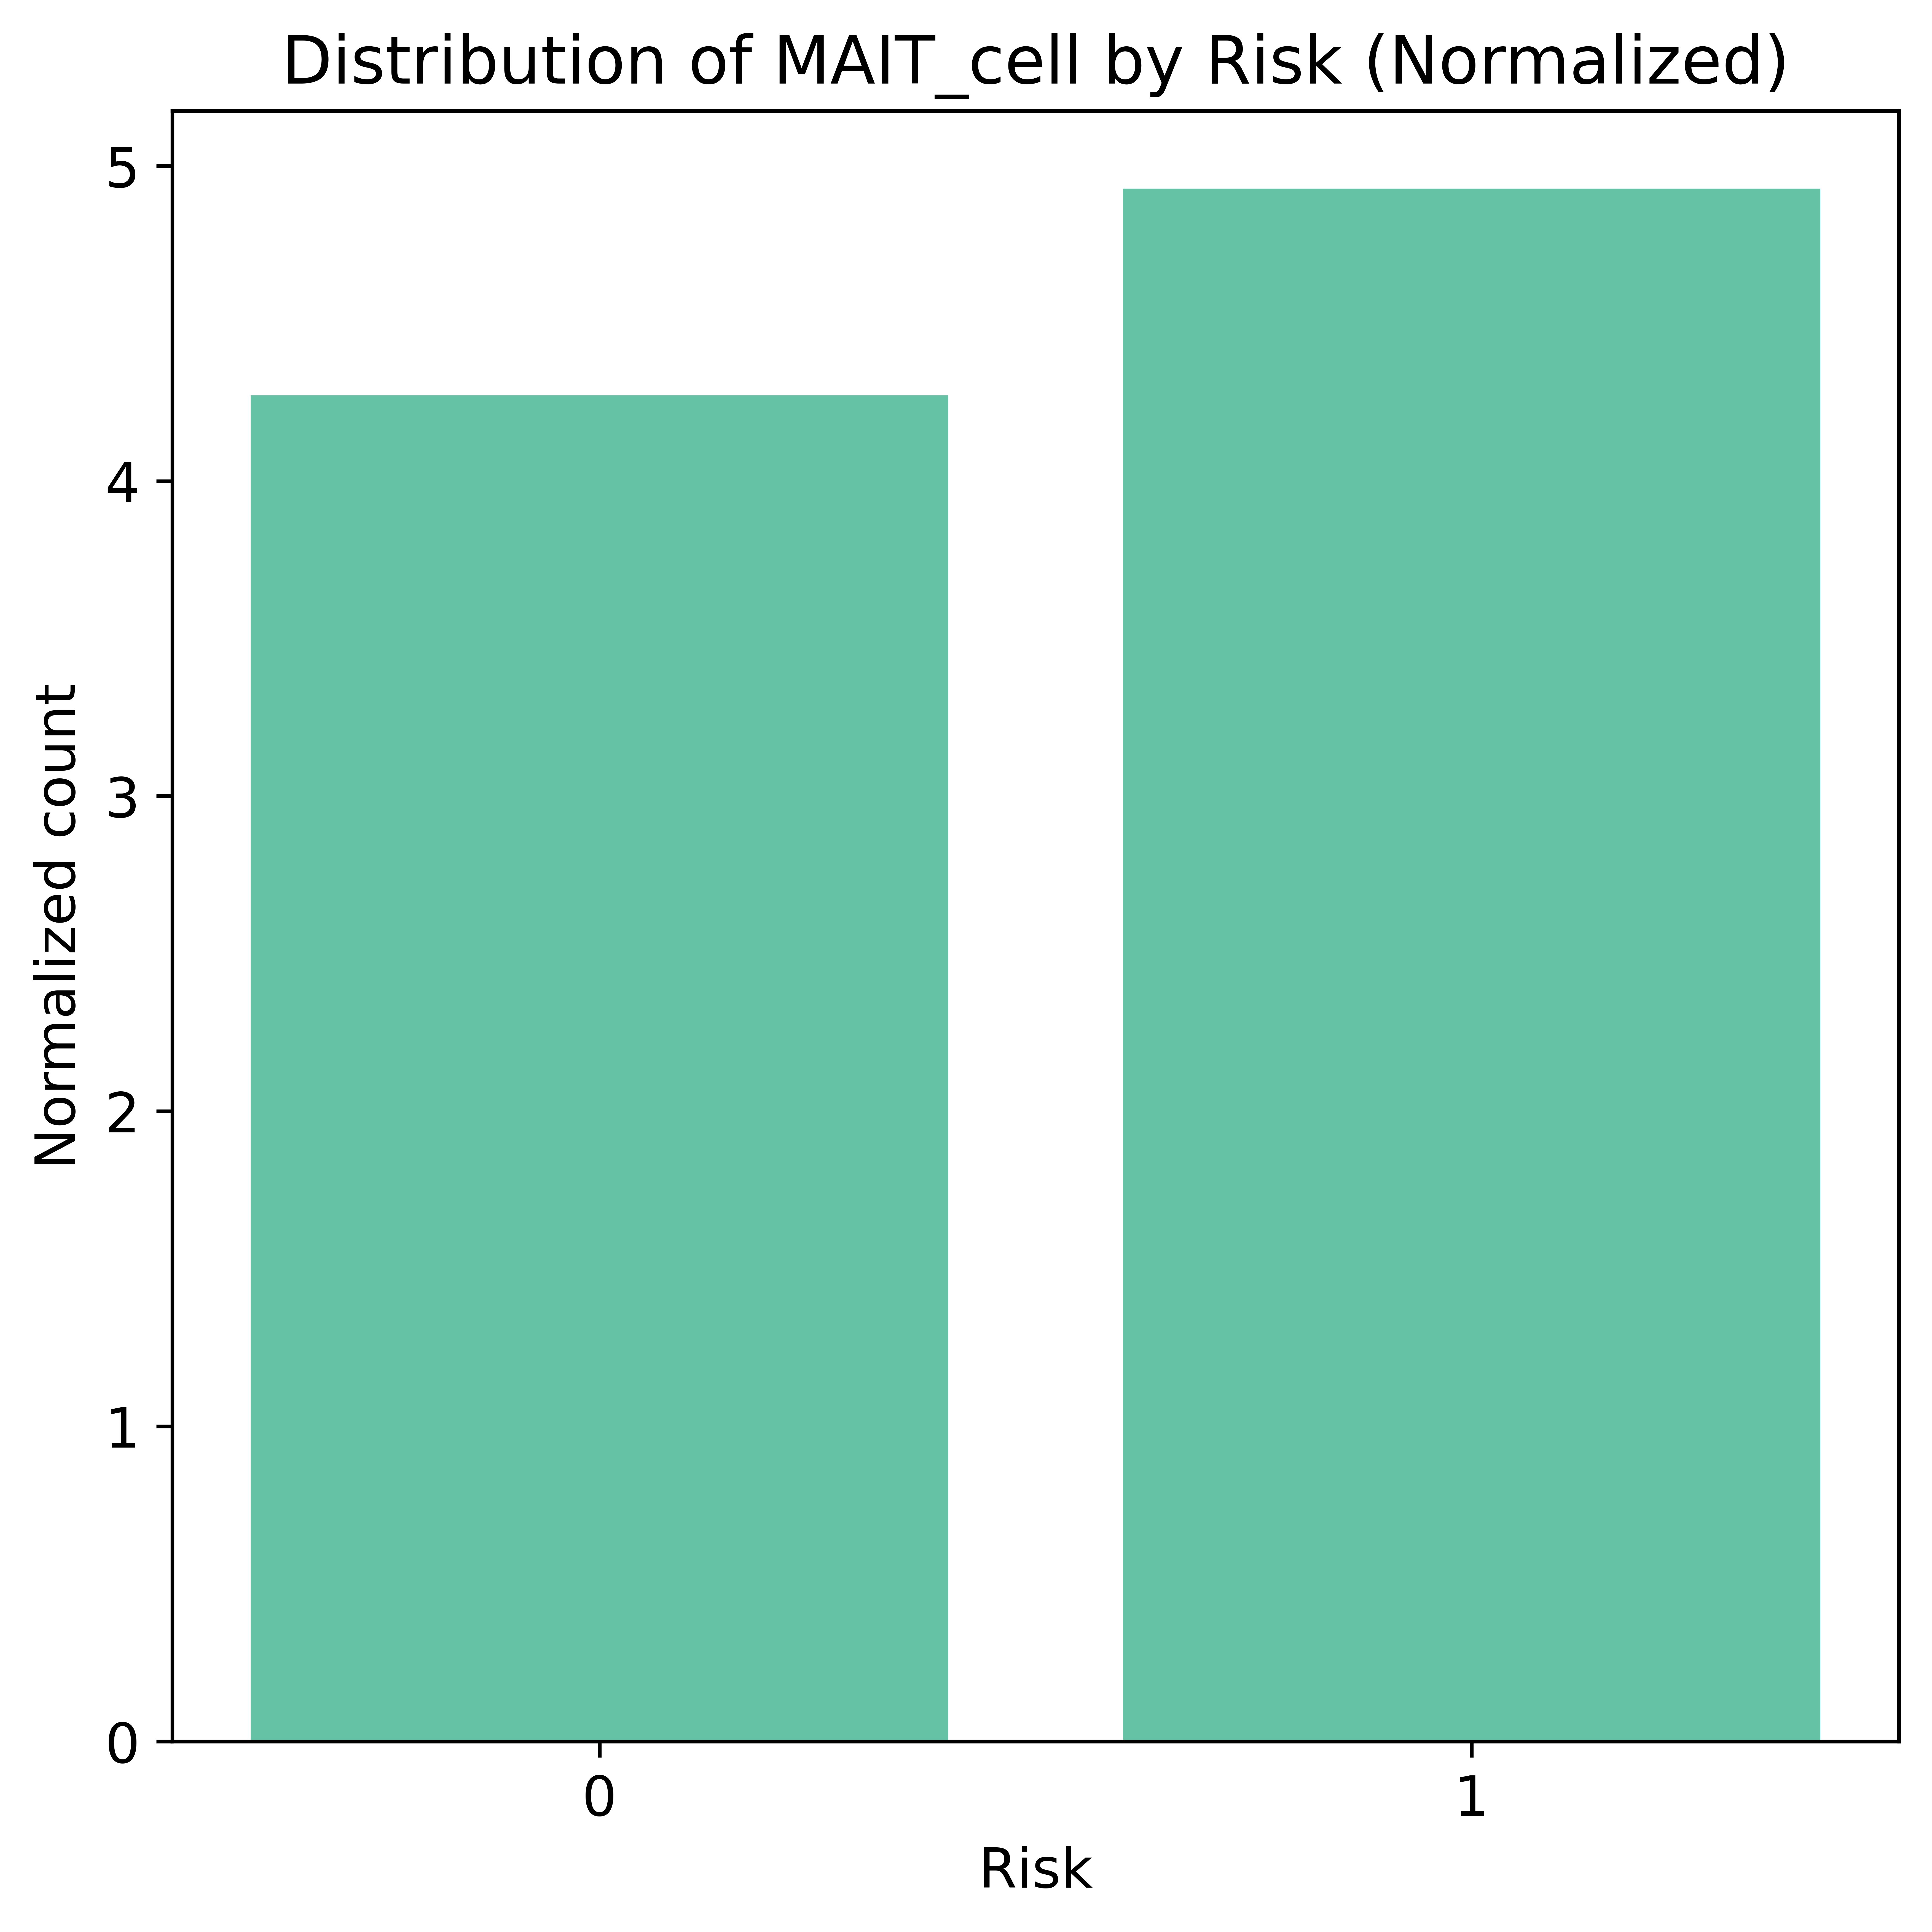

In [17]:
# Filter the data to include only rows where MAIT_cell is 'MAIT_cell'
MAIT_data = CRC_embedding_data_M0[CRC_embedding_data_M0['MAIT_cell'] == 'MAIT_cell']

plt.rcParams.update({'font.size': 12})

# Calculate the number of unique subjects in each risk group within the MAIT_data
low_risk_subjects = MAIT_data[MAIT_data['Risk'] == 0]['Subject'].nunique()
high_risk_subjects = MAIT_data[MAIT_data['Risk'] == 1]['Subject'].nunique()

# Check the counts of MAIT cells in each risk group
low_risk_count = MAIT_data[MAIT_data['Risk'] == 0].shape[0]
high_risk_count = MAIT_data[MAIT_data['Risk'] == 1].shape[0]

# Normalize the counts by the number of subjects in the MAIT_data
low_risk_normalized = low_risk_count / low_risk_subjects if low_risk_subjects != 0 else 0
high_risk_normalized = high_risk_count / high_risk_subjects if high_risk_subjects != 0 else 0

print(f"There are {low_risk_subjects} subjects in the low-risk group and {high_risk_subjects} subjects in the high-risk group.")
print(f"There are {low_risk_count} MAIT cells in the low-risk group and {high_risk_count} MAIT cells in the high-risk group.")
print(f"The normalized counts are {low_risk_normalized:.2f} and {high_risk_normalized:.2f} for low and high risk groups respectively.")

# Plot distributions of MAIT_cell by risk using matplotlib
risk_counts = [low_risk_normalized, high_risk_normalized]
risk_labels = ['0', '1']

fig, ax = plt.subplots(figsize=(6, 6), dpi=1200)

colors = ['#66c2a5']  # Custom colors
ax.bar(risk_labels, risk_counts, color=colors)
ax.set_title('Distribution of MAIT_cell by Risk (Normalized)')
ax.set_ylabel('Normalized count')
ax.set_xlabel('Risk')
plt.tight_layout()
plt.savefig('/home/CODON_CVC/CRC_blood/plots/distribution_of_MAIT_cell_by_risk_group_normalized.png', dpi=800)
plt.show()

There are 393 patients in the low-risk group and 69 patients in the high-risk group.


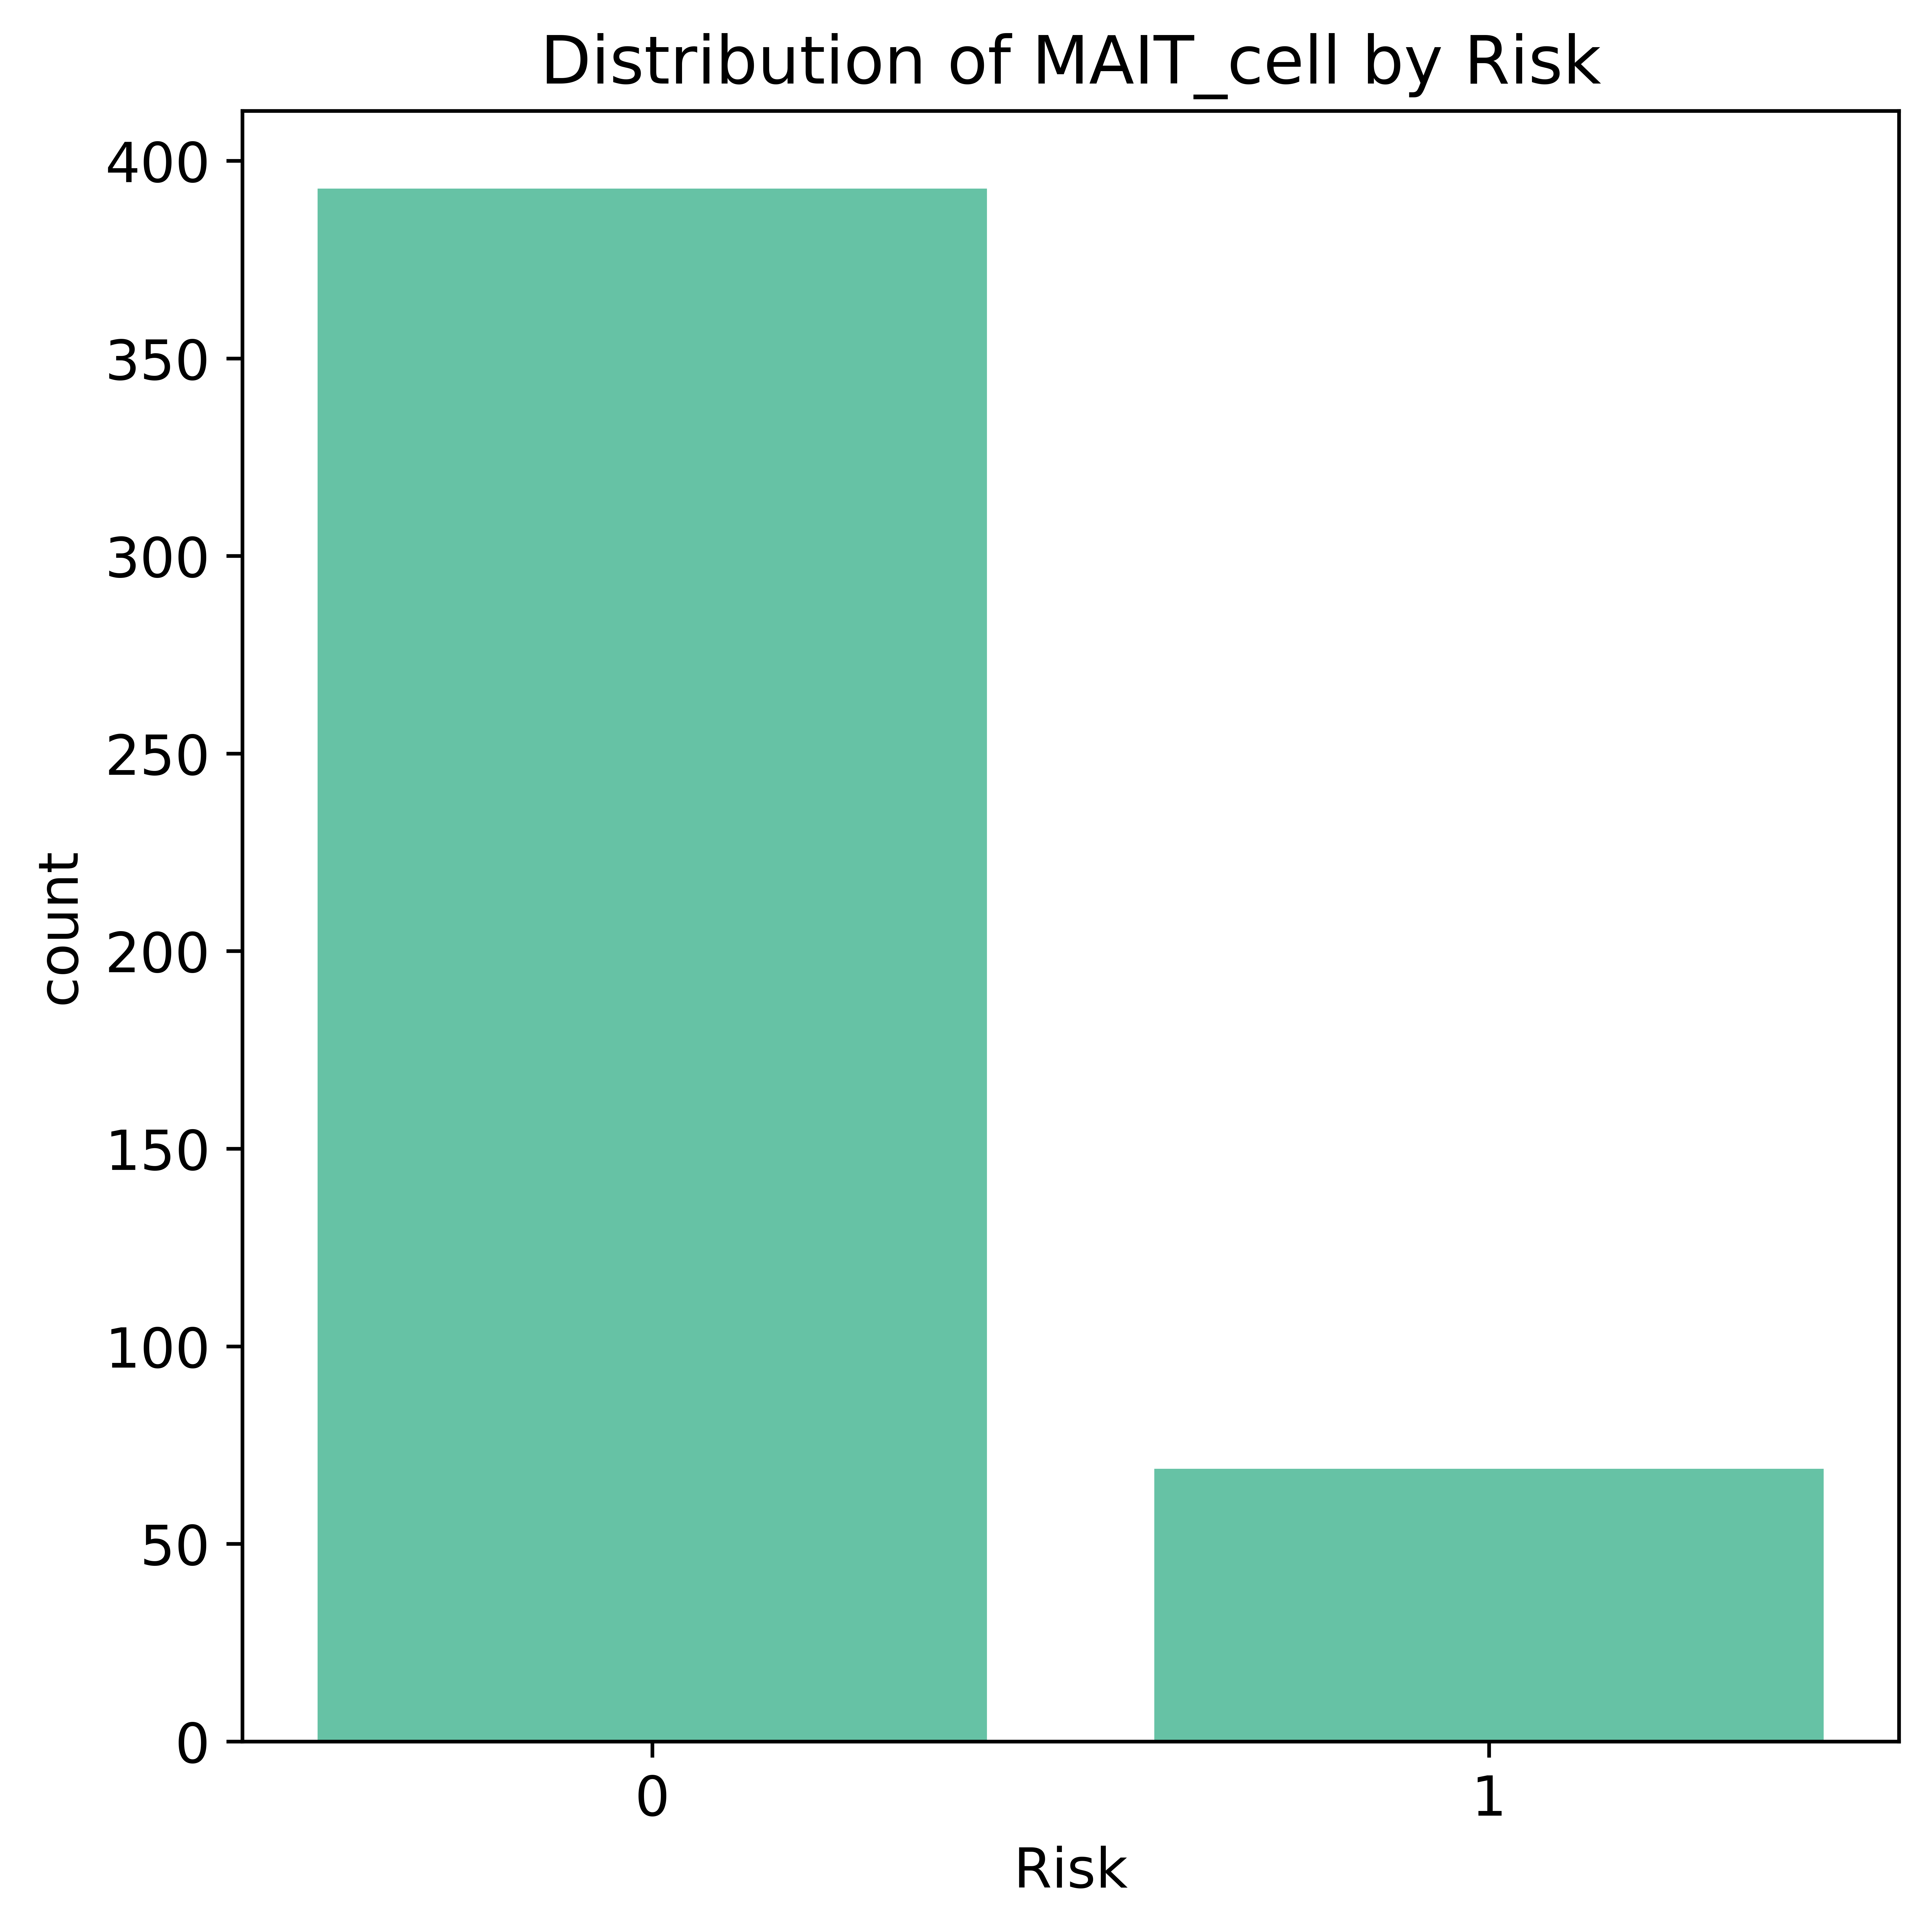

In [9]:
# Filter the data to include only rows where MAIT_cell is 'MAIT_cell'
MAIT_data = CRC_embedding_data_M0[CRC_embedding_data_M0['MAIT_cell'] == 'MAIT_cell']

plt.rcParams.update({'font.size': 12})

# Check the counts of MAIT cells in each risk group
low_risk_count = MAIT_data[MAIT_data['Risk'] == 0].shape[0]
high_risk_count = MAIT_data[MAIT_data['Risk'] == 1].shape[0]

print(f"There are {low_risk_count} patients in the low-risk group and {high_risk_count} patients in the high-risk group.")

# Plot distributions of MAIT_cell by risk using matplotlib
risk_counts = [low_risk_count, high_risk_count]
risk_labels = ['0', '1']

fig, ax = plt.subplots(figsize=(6, 6), dpi=1200)

colors = ['#66c2a5']  # Custom colors
ax.bar(risk_labels, risk_counts, color=colors)
ax.set_title('Distribution of MAIT_cell by Risk')
ax.set_ylabel('count')
ax.set_xlabel('Risk')

plt.tight_layout()
plt.savefig('/home/ubuntu/CRC_blood/plots/distribution_of_MAIT_cell_by_risk_group_v2.png', dpi=800)
plt.show()



Statistical Tests

In [15]:
from scipy.stats import chi2_contingency

# Function to perform chi-square test for categorical features
def chi_square_test(feature):
    contingency_table = pd.crosstab(CRC_embedding_data_M0[feature], CRC_embedding_data_M0['Risk'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p

# Apply chi-square test to categorical features
categorical_features = ['Public_Private_label', 'chain', 'MAIT_cell']
chi_square_results = {feature: chi_square_test(feature) for feature in categorical_features}

print('Chi-square test results for categorical features:')
chi_square_results

Chi-square test results for categorical features:


{'Public_Private_label': (57.46181355930996, 3.446051715360615e-14),
 'chain': (92.5310337863639, 6.627728179073631e-22),
 'MAIT_cell': (6.664377039218911, 0.009835903193453111)}

##### Unique Sequence Analysis by Risk 

In [16]:
# Group the sequences by risk group
Risk_0_uniques = set(CRC_embedding_data_M0[CRC_embedding_data_M0['Risk'] == 0]['aaSeqCDR3'])
Risk_1_uniques = set(CRC_embedding_data_M0[CRC_embedding_data_M0['Risk'] == 1]['aaSeqCDR3'])

In [18]:
unique_to_Risk_0 = Risk_0_uniques - Risk_1_uniques
unique_to_Risk_1 = Risk_1_uniques - Risk_0_uniques

print(f'Number of overall unique sequences: {len(set(CRC_embedding_data_M0["aaSeqCDR3"])) }')
print(f'Unique to Risk 0: {len(unique_to_Risk_0)}')
print(f'Unique to Risk 1: {len(unique_to_Risk_1)}')

Number of overall unique sequences: 723234
Unique to Risk 0: 632654
Unique to Risk 1: 74790


In [19]:
# Filter DataFrame for unique sequences by risk
df_unique_to_Risk_0 = CRC_embedding_data_M0[CRC_embedding_data_M0['aaSeqCDR3'].isin(unique_to_Risk_0)]
df_unique_to_Risk_1 = CRC_embedding_data_M0[CRC_embedding_data_M0['aaSeqCDR3'].isin(unique_to_Risk_1)]

Risk 1

In [20]:
# Group by Sequence and count the number of unique subjects
sequence_subjects_agg = df_unique_to_Risk_1.groupby('aaSeqCDR3')['Subject'].agg(list).reset_index()

# Create a new column for unique subject count
sequence_subjects_agg['Unique_Subject_Count'] = sequence_subjects_agg['Subject'].apply(lambda x: len(set(x)))

# Sort the dataframe by the unique subject count in descending order
sequence_subjects_agg_sorted = sequence_subjects_agg.sort_values(by='Unique_Subject_Count', ascending=False)
sequence_subjects_agg_sorted

aaSeqCDR3                          Subject  Unique_Subject_Count
59817    CAVNPTNAGKSTF   [pool4_S9, pool8_S3, pool9_S2]                     3
25300    CASSLDVQETQYF   [pool1_S2, pool4_S6, pool7_S1]                     3
6531      CALHTNAGKSTF   [pool2_S4, pool3_S9, pool7_S6]                     3
31385   CASSLSQVNTEAFF   [pool3_S9, pool7_S6, pool8_S3]                     3
13519  CASRPGTENTGELFF  [pool1_S18, pool1_S7, pool4_S6]                     3
...                ...                              ...                   ...
24997   CASSLDQGLETQYF                       [pool5_S4]                     1
24996  CASSLDQGAWNTIYF                       [pool7_S6]                     1
24995  CASSLDQASTDTQYF                       [pool3_S9]                     1
24994  CASSLDQASKEKLFF                       [pool2_S4]                     1
25003  CASSLDQGWTDTQYF                       [pool3_S9]                     1

[74790 rows x 3 columns]

In [21]:
# Filter sequences that appear in at least 3 subjects
key_risk1_sequences = sequence_subjects_agg_sorted[sequence_subjects_agg_sorted['Unique_Subject_Count'] >= 3]
print(f'Number of unique sequences in Risk 1 that appear in at least 3 subjects: {len(key_risk1_sequences)}')

Number of unique sequences in Risk 1 that appear in at least 3 subjects: 8


In [22]:
key_risk1_sequences_list = key_risk1_sequences['aaSeqCDR3'].tolist()

In [23]:
# subset df_unique_to_Risk_1 for sequences that appear in at least 3 subjects
df_unique_to_Risk_1_key_publicity3 = df_unique_to_Risk_1[df_unique_to_Risk_1['aaSeqCDR3'].isin(key_risk1_sequences['aaSeqCDR3'])]

In [24]:
# V and J gene usage for key sequences in Risk 1
df_unique_to_Risk_1_key_publicity3.groupby('aaSeqCDR3')['v_gene'].unique(), df_unique_to_Risk_1_key_publicity3.groupby('aaSeqCDR3')['j_gene'].unique()

(aaSeqCDR3
 CAGGDSGNTPLVF         [TRAV27, TRAV35]
 CALHTNAGKSTF          [TRAV6, TRAV9-2]
 CASRPGTENTGELFF       [TRBV9, TRBV5-1]
 CASSLDVQETQYF         [TRBV7-9, TRBV9]
 CASSLGRGGQETQYF     [TRBV7-2, TRBV5-1]
 CASSLSQVNTEAFF               [TRBV5-1]
 CASSLTGVGDTQYF     [TRBV7-3, TRBV12-3]
 CAVNPTNAGKSTF      [TRAV8-1, TRAV12-2]
 Name: v_gene, dtype: object,
 aaSeqCDR3
 CAGGDSGNTPLVF       [TRAJ29]
 CALHTNAGKSTF        [TRAJ27]
 CASRPGTENTGELFF    [TRBJ2-2]
 CASSLDVQETQYF      [TRBJ2-5]
 CASSLGRGGQETQYF    [TRBJ2-5]
 CASSLSQVNTEAFF     [TRBJ1-1]
 CASSLTGVGDTQYF     [TRBJ2-3]
 CAVNPTNAGKSTF       [TRAJ27]
 Name: j_gene, dtype: object)

Risk 0

In [25]:
# Group by Sequence and count the number of unique subjects
sequence_subjects_agg = df_unique_to_Risk_0.groupby('aaSeqCDR3')['Subject'].agg(list).reset_index()

# Create a new column for unique subject count
sequence_subjects_agg['Unique_Subject_Count'] = sequence_subjects_agg['Subject'].apply(lambda x: len(set(x)))

# Sort the dataframe by the unique subject count in descending order
sequence_subjects_agg_sorted = sequence_subjects_agg.sort_values(by='Unique_Subject_Count', ascending=False)
sequence_subjects_agg_sorted

aaSeqCDR3                                            Subject  \
10945       CAASGGSNYKLTF  [pool1_S19, pool1_S3, pool1_S5, pool2_S24, poo...   
12749       CAASKAAGNKLTF  [pool1_S3, pool1_S9, pool1_S9, pool1_S9, pool1...   
60762        CALNQAGTALIF  [pool1_S1, pool1_S1, pool1_S1, pool1_S1, pool1...   
59661        CALKAAGNKLTF  [pool1_S1, pool1_S11, pool1_S11, pool1_S11, po...   
7158        CAARNSGNTPLVF  [pool1_S5, pool1_S8, pool2_S13, pool3_S18, poo...   
...                   ...                                                ...   
218286    CASSLEGLATGELFF                                         [pool5_S1]   
218287  CASSLEGLATYTDTQYF                                         [pool7_S9]   
218288   CASSLEGLAVFYEQYF                                         [pool3_S1]   
218289    CASSLEGLAVYEQYF                                         [pool3_S8]   
218280  CASSLEGLASFPYEQYF                                         [pool1_S9]   

        Unique_Subject_Count  
10945                     35  
12749                     29  
60762                     29  
59661                     29  
7158                      23  
...                      ...  
218286                     1  
218287                     1  
218288                     1  
218289                     1  
218280                     1  

[632654 rows x 3 columns]

In [26]:
risk0_public = sequence_subjects_agg_sorted[sequence_subjects_agg_sorted['Unique_Subject_Count'] >= 2]
risk0_public

aaSeqCDR3                                            Subject  \
10945    CAASGGSNYKLTF  [pool1_S19, pool1_S3, pool1_S5, pool2_S24, poo...   
12749    CAASKAAGNKLTF  [pool1_S3, pool1_S9, pool1_S9, pool1_S9, pool1...   
60762     CALNQAGTALIF  [pool1_S1, pool1_S1, pool1_S1, pool1_S1, pool1...   
59661     CALKAAGNKLTF  [pool1_S1, pool1_S11, pool1_S11, pool1_S11, po...   
7158     CAARNSGNTPLVF  [pool1_S5, pool1_S8, pool2_S13, pool3_S18, poo...   
...                ...                                                ...   
760       CAADYGNNRLAF                              [pool5_S3, pool9_S23]   
17561   CAASTSPGTYKYIF                               [pool2_S5, pool5_S3]   
299743  CASSPGQATGELFF                             [pool7_S16, pool7_S17]   
732      CAADSNTGNQFYF                             [pool8_S23, pool9_S16]   
18221    CAASWGSQGNLIF                              [pool8_S20, pool9_S1]   

        Unique_Subject_Count  
10945                     35  
12749                     29  
60762                     29  
59661                     29  
7158                      23  
...                      ...  
760                        2  
17561                      2  
299743                     2  
732                        2  
18221                      2  

[41737 rows x 3 columns]

In [27]:
collections.Counter(sequence_subjects_agg_sorted['Unique_Subject_Count'])

Counter({1: 590917,
         2: 28396,
         3: 7326,
         4: 2910,
         5: 1359,
         6: 672,
         7: 410,
         8: 231,
         9: 140,
         10: 91,
         11: 48,
         12: 47,
         13: 40,
         14: 19,
         16: 15,
         15: 12,
         18: 4,
         17: 4,
         29: 3,
         22: 3,
         20: 2,
         19: 2,
         35: 1,
         23: 1,
         21: 1})

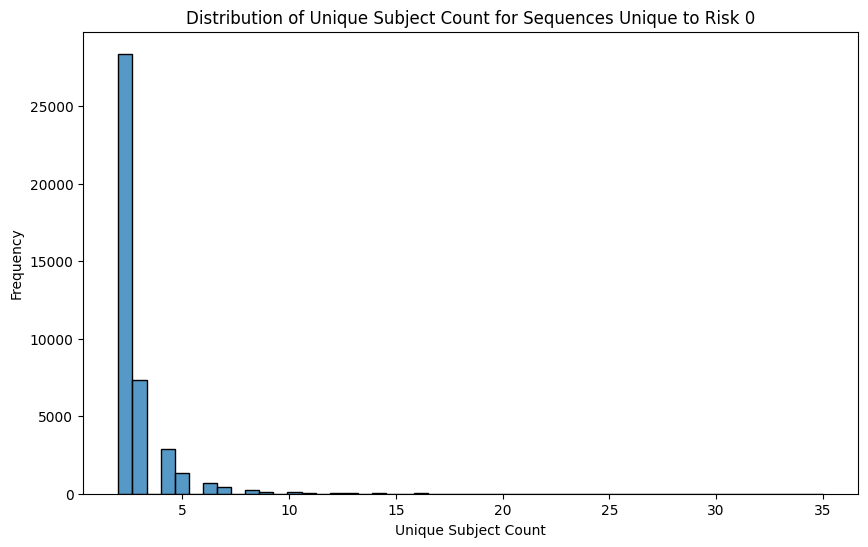

In [19]:
# plot the distribution of unique subject count
plt.figure(figsize=(10, 6))
sns.histplot(risk0_public['Unique_Subject_Count'], bins=50)
plt.title('Distribution of Unique Subject Count for Sequences Unique to Risk 0')
plt.xlabel('Unique Subject Count')
plt.ylabel('Frequency')
plt.savefig('/home/ubuntu/CODON_CVC/CRC_blood/plots/distribution_of_unique_subject_count_for_sequences_unique_to_risk_0_publicity_10.png')
plt.show()

#### Analyse the 13 Shared Sequences (across 3 datasets) with Risk Groups

In [28]:
top_13_df = pd.read_csv("~/CODON_CVC/single_cell_data/shared_13_sequences_CRC_zhang_gse164522.csv")
top_13_df = top_13_df['CDR3.aa'].tolist()

top_13 = set(top_13_df)
top_13

{'CAFLNAGNMLTF',
 'CASRLAGETQYF',
 'CASSLAGGGTEAFF',
 'CASSLDGKGYTF',
 'CASSLGGGLYEQYF',
 'CASSSREETQYF',
 'CAVMDSSYKLIF',
 'CAVQGTGAGSYQLTF',
 'CAVREASGTYKYIF',
 'CAVSESSGTYKYIF',
 'CLVGDRGTGGFKTIF',
 'CSAKRGPSTDTQYF',
 'CSAREREYEQYF'}

In [29]:
# are there top 13 sequences unique to risk 1?
public_risk1_join_top_13 = df_unique_to_Risk_1[df_unique_to_Risk_1['aaSeqCDR3'].isin(top_13)]
public_risk1_join_top_13['aaSeqCDR3'].value_counts()

Series([], Name: count, dtype: int64)

In [30]:
# are there top 13 sequences unique to risk 0?
public_risk0_join_top_13 = df_unique_to_Risk_0[df_unique_to_Risk_0['aaSeqCDR3'].isin(top_13)]
public_risk0_join_top_13['aaSeqCDR3'].value_counts()

aaSeqCDR3
CASSLAGGGTEAFF     12
CAVMDSSYKLIF        6
CASSLDGKGYTF        3
CLVGDRGTGGFKTIF     2
CAVSESSGTYKYIF      2
CAVREASGTYKYIF      2
CAFLNAGNMLTF        1
CSAREREYEQYF        1
CSAKRGPSTDTQYF      1
CASSSREETQYF        1
Name: count, dtype: int64

In [31]:
# dataframe of the unique sequences, and the subjects they appear in, and the number of subjects
df_public_risk0_join_top_13 = public_risk0_join_top_13.groupby('aaSeqCDR3')['Subject'].agg(list).reset_index()
df_public_risk0_join_top_13['Unique_Subject_Count_M0'] = df_public_risk0_join_top_13['Subject'].apply(lambda x: len(set(x)))
# sorted dataframe by the unique subject count in descending order
df_public_risk0_join_top_13 = df_public_risk0_join_top_13.sort_values(by='Unique_Subject_Count_M0', ascending=False)
df_public_risk0_join_top_13

aaSeqCDR3                                            Subject  \
1   CASSLAGGGTEAFF  [pool1_S11, pool1_S22, pool3_S13, pool3_S19, p...   
4     CAVMDSSYKLIF  [pool1_S1, pool1_S5, pool1_S6, pool2_S13, pool...   
2     CASSLDGKGYTF                   [pool1_S6, pool3_S18, pool7_S13]   
7  CLVGDRGTGGFKTIF                              [pool4_S8, pool6_S24]   
5   CAVREASGTYKYIF                             [pool5_S12, pool7_S19]   
6   CAVSESSGTYKYIF                              [pool6_S8, pool7_S19]   
0     CAFLNAGNMLTF                                         [pool7_S4]   
3     CASSSREETQYF                                        [pool7_S20]   
8   CSAKRGPSTDTQYF                                         [pool1_S6]   
9     CSAREREYEQYF                                        [pool1_S11]   

   Unique_Subject_Count_M0  
1                       12  
4                        6  
2                        3  
7                        2  
5                        2  
6                        2  
0                        1  
3                        1  
8                        1  
9                        1

In [32]:
CRC_embedding_data_top_13 = CRC_embedding_data[CRC_embedding_data['aaSeqCDR3'].isin(top_13)]
CRC_embedding_data_top_13 = CRC_embedding_data_top_13.groupby('aaSeqCDR3')['Subject'].agg(list).reset_index()
CRC_embedding_data_top_13['Unique_Subject_Count_All_Samples'] = CRC_embedding_data_top_13['Subject'].apply(lambda x: len(set(x)))
# sort the dataframe by the unique subject count in descending order
CRC_embedding_data_top_13 = CRC_embedding_data_top_13.sort_values(by='Unique_Subject_Count_All_Samples', ascending=False)
CRC_embedding_data_top_13

aaSeqCDR3                                            Subject  \
2    CASSLAGGGTEAFF  [pool1_S11, pool1_S22, pool3_S13, pool3_S19, p...   
6      CAVMDSSYKLIF  [pool1_S1, pool1_S5, pool1_S6, pool2_S13, pool...   
7   CAVQGTGAGSYQLTF  [pool1_S8, pool3_S10, pool3_S12, pool5_S17, po...   
4    CASSLGGGLYEQYF  [pool1_S21, pool1_S6, pool1_S7, pool4_S7, pool...   
1      CASRLAGETQYF  [pool5_S12, pool5_S4, pool6_S17, pool6_S23, po...   
8    CAVREASGTYKYIF       [pool4_S24, pool5_S12, pool7_S19, pool8_S10]   
3      CASSLDGKGYTF                   [pool1_S6, pool3_S18, pool7_S13]   
9    CAVSESSGTYKYIF                    [pool6_S8, pool7_S19, pool8_S8]   
5      CASSSREETQYF                  [pool3_S12, pool6_S19, pool7_S20]   
12     CSAREREYEQYF                   [pool1_S11, pool4_S16, pool8_S8]   
10  CLVGDRGTGGFKTIF                              [pool4_S8, pool6_S24]   
0      CAFLNAGNMLTF                                         [pool7_S4]   
11   CSAKRGPSTDTQYF                                         [pool1_S6]   

    Unique_Subject_Count_All_Samples  
2                                 14  
6                                  7  
7                                  6  
4                                  5  
1                                  5  
8                                  4  
3                                  3  
9                                  3  
5                                  3  
12                                 3  
10                                 2  
0                                  1  
11                                 1

##### Significance Calculation with P-value 

Fisher Exact P Value - Not considering risk group size

In [ ]:
# Define the contingency table
contingency_table = [[6, 0], [7, 13]]

# Perform Fisher's Exact Test
odds_ratio, p_value = stats.fisher_exact(contingency_table)

p_value, odds_ratio

Re-sampling Approach

In [ ]:
# Subset the data
risk_0 = CRC_embedding_data_M0[CRC_embedding_data_M0['Risk'] == 0]
risk_1 = CRC_embedding_data_M0[CRC_embedding_data_M0['Risk'] == 1]

# Function to count how many of the 13 sequences appear in a given subset
def count_sequences(df, sequences):
    return df[df['aaSeqCDR3'].isin(sequences)]['aaSeqCDR3'].nunique()

# Observed count in Risk=1 group
observed_count = count_sequences(risk_0, top_13)

# Resampling
num_samples = 1000
resampled_counts = []

for _ in range(num_samples):
    resampled_subset = risk_0.sample(n=14, replace=False)
    resampled_count = count_sequences(resampled_subset, top_13)
    resampled_counts.append(resampled_count)

# Convert to numpy array for analysis
resampled_counts = np.array(resampled_counts)

# Calculate mean and standard deviation of the resampled counts
mean_resampled = np.mean(resampled_counts)
std_resampled = np.std(resampled_counts)

# Calculate empirical p-value
p_value_empirical = np.sum(resampled_counts >= observed_count) / num_samples

# Display the results
mean_resampled = np.mean(resampled_counts)
std_resampled = np.std(resampled_counts)

mean_resampled, std_resampled, observed_count, p_value_empirical
print(f'Mean of resampled counts: {mean_resampled}')
print(f'Standard deviation of resampled counts: {std_resampled}')
print(f'Observed count in Risk=0 group: {observed_count}')
print(f'Empirical p-value: {p_value_empirical}')

In [ ]:
# Count of unique sequences in each risk group
observed_risk0_only = set(risk_0[risk_0['aaSeqCDR3'].isin(top_13)]['aaSeqCDR3']) - set(risk_1[risk_1['aaSeqCDR3'].isin(top_13)]['aaSeqCDR3'])
observed_shared = set(risk_1[risk_1['aaSeqCDR3'].isin(top_13)]['aaSeqCDR3']) & set(risk_0[risk_0['aaSeqCDR3'].isin(top_13)]['aaSeqCDR3'])

observed_risk0_only_count = len(observed_risk0_only)
observed_shared_count = len(observed_shared)

observed_risk0_only_count, observed_shared_count

In [ ]:
# Function to count unique sequences in resampled data
def count_unique_sequences_in_resampled_data(risk_0, risk_1, sequences, sample_size):
    risk_0_sample = risk_0.sample(n=sample_size, replace=False)
    risk_1_sample = risk_1  # all patients in risk 1 group
    
    risk0_only_resample = set(risk_0_sample[risk_0_sample['aaSeqCDR3'].isin(sequences)]['aaSeqCDR3']) - set(risk_1_sample[risk_1_sample['aaSeqCDR3'].isin(sequences)]['aaSeqCDR3'])
    shared_resample = set(risk_0_sample[risk_0_sample['aaSeqCDR3'].isin(sequences)]['aaSeqCDR3']) & set(risk_1_sample[risk_1_sample['aaSeqCDR3'].isin(sequences)]['aaSeqCDR3'])
    
    return len(risk0_only_resample), len(shared_resample)

# Perform the resampling test
num_resamples = 1000
risk0_only_counts = []
shared_counts = []

sample_size = len(risk_1)

for _ in range(num_resamples):
    risk0_only_count, shared_count = count_unique_sequences_in_resampled_data(risk_0, risk_1, top_13, sample_size)
    risk0_only_counts.append(risk0_only_count)
    shared_counts.append(shared_count)

# Convert to numpy arrays for analysis
risk0_only_counts = np.array(risk0_only_counts)
shared_counts = np.array(shared_counts)

In [ ]:
# Calculate empirical p-values
p_value_risk0_only = np.sum(risk0_only_counts >= observed_risk0_only_count) / num_resamples
p_value_shared = np.sum(shared_counts >= observed_shared_count) / num_resamples

# Display the results
print(f'Observed count of unique sequences in Risk 0 only: {observed_risk0_only_count}')
print(f'Observed count of shared unique sequences: {observed_shared_count}')
print(f'Empirical p-value for unique sequences in Risk 0 only: {p_value_risk0_only}')
print(f'Empirical p-value for shared unique sequences: {p_value_shared}')

In [ ]:
# Plot the distribution of the resampling test results for unique sequences in Risk 0
plt.figure(figsize=(10, 6))
plt.hist(risk0_only_counts, bins=30, alpha=0.75, label='Resampled Risk 0 Unique Counts')
plt.axvline(observed_risk0_only_count, color='red', linestyle='dashed', linewidth=2, label='Observed Risk 0 Unique Count')
plt.xlabel('Number of Unique Sequences')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Sequence Counts in Risk 0 (Resampling Test)')
plt.legend()
plt.savefig('/home/ubuntu/CODON_CVC/CRC_blood/plots/p-value_distribution_of_unique_sequence_counts_in_risk_0_resampling_test.png')
plt.show()

# Plot the distribution of the resampling test results for shared sequences
plt.figure(figsize=(10, 6))
plt.hist(shared_counts, bins=30, alpha=0.75, label='Resampled Shared Counts')
plt.axvline(observed_shared_count, color='red', linestyle='dashed', linewidth=2, label='Observed Shared Count')
plt.xlabel('Number of Shared Sequences')
plt.ylabel('Frequency')
plt.title('Distribution of Shared Sequence Counts (Resampling Test)')
plt.legend()
plt.savefig('/home/ubuntu/CODON_CVC/CRC_blood/plots/p-value_distribution_of_shared_sequence_counts_resampling_test.png')
plt.show()

##### Shared 13 Sequences Analysis and Heatmap Plotting

In [33]:
# Filter the dataframe to include only the top 13 sequences present in the data
present_sequences = CRC_embedding_data_M0['aaSeqCDR3'].isin(top_13)
filtered_df = CRC_embedding_data_M0[present_sequences]

# Create a pivot table for sequences present in subjects
pivot_df = filtered_df.pivot_table(index='aaSeqCDR3', columns='Subject', aggfunc='size', fill_value=0)

# Add the risk information
subject_risk = CRC_embedding_data_M0.drop_duplicates(subset=['Subject'])[['Subject', 'Risk']].set_index('Subject')['Risk']
pivot_df = pd.concat([pivot_df, pd.DataFrame(subject_risk).T])

# replace NaN with 0
pivot_df = pivot_df.fillna(0)

# make all values above 1 to 1
pivot_df = pivot_df.applymap(lambda x: 1 if x > 1 else x)

pivot_df

/tmp/ipykernel_5422/952836381.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df = pivot_df.applymap(lambda x: 1 if x > 1 else x)


Subject          pool1_S1  pool1_S11  pool1_S21  pool1_S22  pool1_S5  \
CAFLNAGNMLTF            0          0          0          0         0   
CASRLAGETQYF            0          0          0          0         0   
CASSLAGGGTEAFF          0          1          0          1         0   
CASSLDGKGYTF            0          0          0          0         0   
CASSLGGGLYEQYF          0          0          1          0         0   
CASSSREETQYF            0          0          0          0         0   
CAVMDSSYKLIF            1          0          0          0         1   
CAVQGTGAGSYQLTF         0          0          0          0         0   
CAVREASGTYKYIF          0          0          0          0         0   
CAVSESSGTYKYIF          0          0          0          0         0   
CLVGDRGTGGFKTIF         0          0          0          0         0   
CSAKRGPSTDTQYF          0          0          0          0         0   
CSAREREYEQYF            0          1          0          0         0   
Risk                    0          0          0          0         0   

Subject          pool1_S6  pool1_S7  pool1_S8  pool2_S13  pool3_S13  ...  \
CAFLNAGNMLTF            0         0         0          0          0  ...   
CASRLAGETQYF            0         0         0          0          0  ...   
CASSLAGGGTEAFF          0         0         0          0          1  ...   
CASSLDGKGYTF            1         0         0          0          0  ...   
CASSLGGGLYEQYF          1         1         0          0          0  ...   
CASSSREETQYF            0         0         0          0          0  ...   
CAVMDSSYKLIF            1         0         0          1          0  ...   
CAVQGTGAGSYQLTF         0         0         1          0          0  ...   
CAVREASGTYKYIF          0         0         0          0          0  ...   
CAVSESSGTYKYIF          0         0         0          0          0  ...   
CLVGDRGTGGFKTIF         0         0         0          0          0  ...   
CSAKRGPSTDTQYF          1         0         0          0          0  ...   
CSAREREYEQYF            0         0         0          0          0  ...   
Risk                    0         1         0          0          0  ...   

Subject          pool9_S12  pool9_S13  pool9_S16  pool9_S21  pool9_S22  \
CAFLNAGNMLTF             0          0          0          0          0   
CASRLAGETQYF             0          0          0          0          0   
CASSLAGGGTEAFF           0          0          0          0          0   
CASSLDGKGYTF             0          0          0          0          0   
CASSLGGGLYEQYF           0          0          0          0          0   
CASSSREETQYF             0          0          0          0          0   
CAVMDSSYKLIF             0          0          0          0          0   
CAVQGTGAGSYQLTF          0          0          0          0          0   
CAVREASGTYKYIF           0          0          0          0          0   
CAVSESSGTYKYIF           0          0          0          0          0   
CLVGDRGTGGFKTIF          0          0          0          0          0   
CSAKRGPSTDTQYF           0          0          0          0          0   
CSAREREYEQYF             0          0          0          0          0   
Risk                     0          0          0          0          0   

Subject          pool9_S23  pool9_S4  pool9_S5  pool9_S6  pool9_S7  
CAFLNAGNMLTF             0         0         0         0         0  
CASRLAGETQYF             0         0         0         0         0  
CASSLAGGGTEAFF           0         0         0         0         0  
CASSLDGKGYTF             0         0         0         0         0  
CASSLGGGLYEQYF           0         0         0         0         0  
CASSSREETQYF             0         0         0         0         0  
CAVMDSSYKLIF             0         0         0         0         0  
CAVQGTGAGSYQLTF          0         0         0         0         0  
CAVREASGTYKYIF           0         0         0

In [35]:
# Extract the risk information
risk_info = pivot_df.loc['Risk']

# Sort the subjects based on risk (red first)
sorted_subjects = risk_info.sort_values(ascending=False).index

# Reorder the DataFrame columns according to the sorted subjects
pivot_df_sorted = pivot_df[sorted_subjects]

# Extract the sequences that are present in the data
present_sequences = [seq for seq in top_13 if seq in pivot_df_sorted.index]

# Count occurrences of each sequence
sequence_counts = pivot_df_sorted.loc[present_sequences].sum(axis=1).sort_values(ascending=False)

# Reorder the present_sequences list based on the sorted order of sequence_counts
sorted_sequences = sequence_counts.index.tolist()

# Create the heatmap for the sequences
plt.figure(figsize=(15, 10), dpi=1200)
sns.heatmap(pivot_df_sorted.loc[sorted_sequences].fillna(0), cmap="YlGnBu", cbar_kws={'label': 'Presence (1) or Absence (0)'}, annot=True)
plt.title('Heatmap of Top TCR Sequences in Subjects')
plt.xlabel('Subjects')
plt.ylabel('TCR Sequences')

# Highlight the risk information
plt.xticks(np.arange(len(pivot_df_sorted.columns)) + 0.5, pivot_df_sorted.columns, rotation=90)
for idx, subject in enumerate(pivot_df_sorted.columns):
    plt.gca().get_xticklabels()[idx].set_color('red' if risk_info[subject] == 1 else 'blue')
    plt.gca().get_xticklabels()[idx].set_fontsize(6)

# Create custom legend
legend_elements = [Patch(facecolor='red', edgecolor='red', label='Risk 1'),
                   Patch(facecolor='blue', edgecolor='blue', label='Risk 0')]
plt.legend(handles=legend_elements, title="Risk Levels", bbox_to_anchor=(1.15, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/home/ubuntu/CODON_CVC/CRC_blood/plots/heatmap_of_top_TCR_sequences_in_subjects.png')
plt.show()


#### Single Cell Dataset Overlap with Risk

##### Zhang Dataset

In [40]:
zhang_data = pd.read_csv('~/CODON_CVC/single_cell_data/Zhang_TCR_CRC_with_TissueType_cleaned.csv')
zhang_data

/tmp/ipykernel_5422/2012014858.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  zhang_data = pd.read_csv('~/CODON_CVC/single_cell_data/Zhang_TCR_CRC_with_TissueType_cleaned.csv')


patient        Cell name Cell typea Subtype Total counts  \
0       P0909     NTC1-0909-ZL        NTC     CD8     461,634    
1       P1228    NTC1-20161228        NTC     CD8     727,142    
2       P0215    NTC1-20170215        NTC     CD8     741,498    
3       P0411    NTC1-20170411        NTC     CD8     363,337    
4       P0413    NTC1-20170413        NTC     CD8     763,339    
...       ...              ...        ...     ...          ...   
19237   P1228  NTH213-20161228        NTH   other       3,132    
19238   P1228  NTH216-20161228        NTH      DN       3,508    
19239   P1228  NTH218-20161228        NTH   other       3,486    
19240   P1228  NTH235-20161228        NTH      DN       2,707    
19241   P1228   PTC39-20161228        PTC   other       4,321    

      Number of expressed geneb       Clusterc Invariant TCR  \
0                        2,528    CD8_C04-GZMK       diverse   
1                        1,838    CD8_C04-GZMK       diverse   
2                        2,658    CD8_C04-GZMK       diverse   
3                        2,385   CD8_C06-CD160       diverse   
4                        2,240   CD8_C06-CD160       diverse   
...                         ...            ...           ...   
19237                    1,760             NaN       diverse   
19238                    2,088             NaN       diverse   
19239                    1,803             NaN       diverse   
19240                    1,667             NaN       diverse   
19241                    2,998             NaN       diverse   

                   Clone ID Clone statusd  ...  TPM (Beta1)  \
0       CRC.P0909_C000402:4        Clonal  ...    1122.0600   
1       CRC.P1228_C000099:2        Clonal  ...     511.9390   
2       CRC.P0215_C000188:3        Clonal  ...    1248.3600   
3       CRC.P0411_C000034:4        Clonal  ...    1304.2700   
4       CRC.P0413_C000031:5        Clonal  ...      51.6831   
...                     ...           ...  ...          ...   
19237   CRC.P1228_C000705:1      NoClonal  ...     482.4600   
19238   CRC.P1228_C000355:1      NoClonal  ...    1615.6400   
19239  CRC.P1228_C000062:18        Clonal  ...     228.0490   
19240   CRC.P1228_C000333:1      NoClonal  ...     678.0260   
19241   CRC.P1228_C000108:1      NoClonal  ...      88.9302   

      Identifier (Beta2) CDR3 (Beta2) VDJ (Beta2)  TPM (Beta2) tissue chain  \
0                    NaN          NaN         NaN          NaN     PN   TRA   
1                    NaN          NaN         NaN          NaN     PN   TRA   
2                    NaN          NaN         NaN          NaN     PN   TRA   
3                    NaN          NaN         NaN          NaN     PN   TRA   
4                    NaN          NaN         NaN          NaN     PN   TRA   
...                  ...          ...         ...          ...    ...   ...   
19237                NaN          NaN         NaN          NaN     PN   TRB   
19238                NaN          NaN         NaN          NaN     PN   TRB   
19239                NaN          NaN         NaN          NaN     PN   TRB   
19240                NaN          NaN         NaN          NaN     PN   TRB   
19241                NaN          NaN         NaN          NaN   PBMC   TRB   

         CDR3 (Alpha1)  publicity unique_patients  
0                  NaN          0               1  
1                  NaN          0               1  
2                  NaN          0               1  
3                  NaN          0               1  
4                  NaN          0               1  
...                ...        ...             ...  
19237  CAVEALPYNTDKLIF          0               1  
19238   CALVHGGSQGNLIF          0               1  
19239   CAVRDMAGGFKTIF          0               1  
19240  CVVSIYGGSNYKLTF          0               1  
19241     CATDVGNEKLTF          0               1  

[19242 rows x 32 columns]

In [41]:
# look for key_risk1_sequences_list in zhang_data
zhang_data['cdr3_aa'].isin(key_risk1_sequences_list)


0        False
1        False
2        False
3        False
4        False
         ...  
19237    False
19238    False
19239    False
19240    False
19241    False
Name: cdr3_aa, Length: 19242, dtype: bool

##### GSE164522 Dataset

In [43]:
GSE164522_data = pd.read_csv('~/CODON_CVC/single_cell_data/GSE164522_colon_data/GSE164522_all_labels_publicity_MAIT.csv')
GSE164522_data[GSE164522_data['cdr3_aa'].isin(key_risk1_sequences_list)]

Unnamed: 0.1  Unnamed: 0             barcode patient         cdr3_aa  \
4488            4488        4488  CACACAATCGCAAGCC-1     P09   CAVNPTNAGKSTF   
119857        119857      119860  GGCTGGTCATGACGGA-1     P13  CASSLTGVGDTQYF   
119858        119858      119861  ACATACGGTATCTGCA-1     P13  CASSLTGVGDTQYF   

                                           cdr3_nt    v_gene   j_gene tissue  \
4488       TGTGCCGTGAATCCCACCAATGCAGGCAAATCAACCTTT  TRAV12-2   TRAJ27   PBMC   
119857  TGTGCCAGCAGCCTCACGGGAGTAGGAGATACGCAGTATTTT   TRBV7-9  TRBJ2-3     MT   
119858  TGTGCCAGCAGCCTCACGGGAGTAGGAGATACGCAGTATTTT   TRBV7-9  TRBJ2-3   PBMC   

        publicity  patient_count chain      MAIT_cell  
4488            0              1   TRA  non-MAIT_cell  
119857          0              1   TRB  non-MAIT_cell  
119858          0              1   TRB  non-MAIT_cell

#### UMAP Investigation by Specific Subjects (correlations)
Note - the UMAP itself was created using the embedding_visualization.ipynb notebook

In [44]:
joined_risk1_risk0 = pd.concat([df_unique_to_Risk_0, df_unique_to_Risk_1])
joined_risk1_risk0

0         1         2         3         4         5         6  \
0        0.439937  0.398926  0.883038 -0.309778  0.687281 -0.018071 -0.026907   
1        0.064476 -0.535562 -0.229020 -0.559817 -0.309919 -0.457965  0.416588   
2        0.684437  0.358636  0.828198  0.857685  0.326658 -0.566441 -0.528951   
3        0.510045  0.095592  1.202585  0.192675  0.224053 -0.000038 -0.049890   
4        0.567597  0.923898  0.725318 -0.011695  0.438315 -0.436650 -0.131053   
...           ...       ...       ...       ...       ...       ...       ...   
1130558  0.647963 -0.299062  0.383775 -0.321980  0.195389 -0.441011 -0.516681   
1130563  0.254198 -0.440824  0.136298  0.387127  0.497613 -0.828747  0.463137   
1130564  0.541553  0.336593  0.112379  0.426565 -0.000811 -0.254982  0.214947   
1130565  0.435719 -0.466634  1.067615  0.595177  0.339548  0.071510  0.211760   
1130567  0.274419 -0.697631  0.260719  0.982819  0.420249  0.256657  0.419642   

                7         8         9  ...   Subject  count  \
0       -0.709836  0.857734  0.049845  ...  pool1_S1      2   
1       -0.022723  0.415283 -0.613813  ...  pool1_S1      1   
2        0.330499 -0.509017 -0.144081  ...  pool1_S1      1   
3       -0.046569  0.606442 -0.075581  ...  pool1_S1      1   
4       -0.322863 -0.001946 -0.632877  ...  pool1_S1      2   
...           ...       ...       ...  ...       ...    ...   
1130558  1.229003  0.619561  0.020306  ...  pool9_S2      1   
1130563  1.015981  1.035212  0.147283  ...  pool9_S2      1   
1130564  0.512396  0.652968 -0.240951  ...  pool9_S2      1   
1130565  0.085957  0.222487  0.000031  ...  pool9_S2      1   
1130567  0.296197  0.666688 -0.489971  ...  pool9_S2      1   

         Public_Private_label    T    N    M  chain      MAIT_cell  N_binary  \
0                      public  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
1                     private  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
2                     private  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
3                     private  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
4                      public  3.0  1.0  0.0    TRA  non-MAIT_cell         1   
...                       ...  ...  ...  ...    ...            ...       ...   
1130558               private  4.0  1.0  0.0    TRB  non-MAIT_cell         1   
1130563               private  4.0  1.0  0.0    TRB  non-MAIT_cell         1   
1130564               private  4.0  1.0  0.0    TRB  non-MAIT_cell         1   
1130565               private  4.0  1.0  0.0    TRB  non-MAIT_cell         1   
1130567               private  4.0  1.0  0.0    TRB  non-MAIT_cell         1   

         Risk  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1130558     1  
1130563     1  
1130564     1  
1130565     1  
1130567     1  

[783639 rows x 784 columns]

In [45]:
subcluster_subject_list = ['pool4_S6','pool5_S4', 'pool7_S1', 'pool9_S2', 'pool8_S4', 'pool1_S7', 'pool3_S9', 'pool7_S6']

CRC_embedding_data_subcluster = joined_risk1_risk0[joined_risk1_risk0['Subject'].isin(subcluster_subject_list)]
CRC_embedding_data_subcluster_public = CRC_embedding_data_subcluster[CRC_embedding_data_subcluster['Public_Private_label'] == 'public']

In [46]:
# display T and N values for each subject
CRC_embedding_data_subcluster_public[['Subject', 'T', 'N']].drop_duplicates()

Subject    T    N
23176   pool1_S7  3.0  2.0
91829   pool3_S9  3.0  2.0
116326  pool4_S6  2.0  2.0
150594  pool5_S4  3.0  2.0
199089  pool7_S1  3.0  2.0
232113  pool7_S6  3.0  2.0
265028  pool8_S4  4.0  0.0
290351  pool9_S2  4.0  1.0

In [47]:
# find which subjects are most correlated when looking at the aaSeqCDR3 sequences they contain
# Create a pivot table for sequences present in subjects
pivot_df_subcluster = CRC_embedding_data_subcluster_public.pivot_table(index='aaSeqCDR3', columns='Subject', aggfunc='size', fill_value=0)

# replace NaN with 0
pivot_df_subcluster = pivot_df_subcluster.fillna(0)

# make all values above 1 to 1
pivot_df_subcluster = pivot_df_subcluster.applymap(lambda x: 1 if x > 1 else x)

# keep only rows that have at least 2 subjects
pivot_df_subcluster = pivot_df_subcluster[pivot_df_subcluster.sum(axis=1) >= 2]

pivot_df_subcluster

/tmp/ipykernel_5422/1228116048.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df_subcluster = pivot_df_subcluster.applymap(lambda x: 1 if x > 1 else x)


Subject         pool1_S7  pool3_S9  pool4_S6  pool5_S4  pool7_S1  pool7_S6  \
aaSeqCDR3                                                                    
CAAANTGGFKTIF          0         1         0         1         0         0   
CAAGGNAGNMLTF          0         0         0         1         1         0   
CAATPGGFKTIF           0         0         0         1         0         0   
CAESSGGGYQKVTF         1         0         0         0         0         1   
CAFIFGNEKLTF           0         0         1         0         0         0   
...                  ...       ...       ...       ...       ...       ...   
CSVDQPQGTDTQYF         1         0         0         0         1         0   
CSVGTGGYNEQFF          1         0         0         0         0         0   
CVVRHYNQGGKLIF         0         0         0         0         1         0   
CVVSVGGSQGNLIF         0         0         0         0         0         0   
SARLMF                 1         1         0         0         0         0   

Subject         pool8_S4  pool9_S2  
aaSeqCDR3                           
CAAANTGGFKTIF          0         0  
CAAGGNAGNMLTF          0         0  
CAATPGGFKTIF           0         1  
CAESSGGGYQKVTF         0         0  
CAFIFGNEKLTF           0         1  
...                  ...       ...  
CSVDQPQGTDTQYF         0         0  
CSVGTGGYNEQFF          0         1  
CVVRHYNQGGKLIF         1         0  
CVVSVGGSQGNLIF         1         1  
SARLMF                 0         0  

[110 rows x 8 columns]

In [48]:
# which are the most common sequences in the subcluster?
# Count occurrences of each sequence
sequence_counts_subcluster = pivot_df_subcluster.sum(axis=1).sort_values(ascending=False)

# Reorder the present_sequences list based on the sorted order of sequence_counts
sorted_sequences_subcluster = sequence_counts_subcluster.index.tolist()

# make a dataframe of the sequences and the number of subjects they appear in
df_subcluster = pd.DataFrame(sequence_counts_subcluster).reset_index()
df_subcluster.columns = ['aaSeqCDR3', 'Number_of_Subjects']
df_subcluster


aaSeqCDR3  Number_of_Subjects
0            SARLMF                   2
1     CAAANTGGFKTIF                   2
2     CAAGGNAGNMLTF                   2
3      CAATPGGFKTIF                   2
4    CAESSGGGYQKVTF                   2
..              ...                 ...
105    CAGGGGNNRLAF                   2
106   CAGRAGSQGNLIF                   2
107  CAGRGGGSQGNLIF                   2
108   CAIRGAGSYQLTF                   2
109    CAISNSNQPQHF                   2

[110 rows x 2 columns]

In [49]:
# according to the pivot table, find the most correlated subjects
corr = pivot_df_subcluster.corr()
corr

Subject   pool1_S7  pool3_S9  pool4_S6  pool5_S4  pool7_S1  pool7_S6  \
Subject                                                                
pool1_S7  1.000000 -0.164276 -0.170400 -0.175228 -0.077629 -0.170400   
pool3_S9 -0.164276  1.000000 -0.146494 -0.000984 -0.280110  0.007465   
pool4_S6 -0.170400 -0.146494  1.000000 -0.157103 -0.098583 -0.054007   
pool5_S4 -0.175228 -0.000984 -0.157103  1.000000 -0.096046 -0.258164   
pool7_S1 -0.077629 -0.280110 -0.098583 -0.096046  1.000000 -0.282383   
pool7_S6 -0.170400  0.007465 -0.054007 -0.258164 -0.282383  1.000000   
pool8_S4 -0.185979 -0.065468 -0.117709 -0.128923 -0.156315 -0.167508   
pool9_S2 -0.100000 -0.264666 -0.264119 -0.125805 -0.077629 -0.076680   

Subject   pool8_S4  pool9_S2  
Subject                       
pool1_S7 -0.185979 -0.100000  
pool3_S9 -0.065468 -0.264666  
pool4_S6 -0.117709 -0.264119  
pool5_S4 -0.128923 -0.125805  
pool7_S1 -0.156315 -0.077629  
pool7_S6 -0.167508 -0.076680  
pool8_S4  1.000000 -0.137270  
pool9_S2 -0.137270  1.000000

In [50]:
# Define the correlation matrix
corr_matrix = np.array(corr)

# Define subjects
subjects = ['pool1_S7', 'pool3_S9', 'pool4_S6', 'pool5_S4', 'pool7_S1', 'pool7_S6', 'pool8_S4', 'pool9_S2']

# Convert correlation matrix to DataFrame for easier manipulation
df_corr = pd.DataFrame(corr_matrix, index=subjects, columns=subjects)

# Get the absolute correlation values
df_abs_corr = df_corr.abs()

# Mask the diagonal values
np.fill_diagonal(df_abs_corr.values, 0)

# Find the most correlated pairs
most_corr_pairs = df_abs_corr.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()

# Create a table of the most correlated pairs
most_corr_pairs_df = most_corr_pairs.reset_index()
most_corr_pairs_df.columns = ['Subject 1', 'Subject 2', 'Correlation']

# Display the top most correlated pairs
top_most_corr_pairs_df = most_corr_pairs_df.head(10)  # Adjust the number to display more or fewer pairs
print(top_most_corr_pairs_df)


  Subject 1 Subject 2  Correlation
0  pool7_S6  pool7_S1     0.282383
1  pool3_S9  pool7_S1     0.280110
2  pool9_S2  pool3_S9     0.264666
3  pool4_S6  pool9_S2     0.264119
4  pool7_S6  pool5_S4     0.258164
5  pool1_S7  pool8_S4     0.185979
6  pool1_S7  pool5_S4     0.175228
7  pool4_S6  pool1_S7     0.170400
8  pool7_S6  pool8_S4     0.167508
9  pool1_S7  pool3_S9     0.164276


#### Risk Classification

##### Feature Selection on Risk Data
Filter data with sequences unique to each group

In [51]:
# make a list of the Risk =0 Subjects and Risk=1 subjects from CRC_embedding_data_M0
risk0_subjects = CRC_embedding_data_M0[CRC_embedding_data_M0['Risk'] == 0]['Subject'].unique()
risk1_subjects = CRC_embedding_data_M0[CRC_embedding_data_M0['Risk'] == 1]['Subject'].unique()

# randomly pick len(risk1_subjects) subjects from risk0_subjects
import random
random.seed(42)
risk0_subjects_sampled = random.sample(list(risk0_subjects), len(risk1_subjects))

In [52]:
# subset the CRC_embedding_data_M0 dataframe for the sampled subjects
CRC_embedding_data_M0_sampled = CRC_embedding_data_M0[CRC_embedding_data_M0['Subject'].isin(risk0_subjects_sampled) | CRC_embedding_data_M0['Subject'].isin(risk1_subjects)]

##### Filter train/test according to most public in train
Code to use publicity within data split

In [54]:
RANDOM_STATE = 42
DATA_TO_USE = CRC_embedding_data_M0_sampled  #df_Risk_0_1

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Split the subjects into training and test sets
unique_subjects = DATA_TO_USE['Subject'].unique()
train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.3, stratify=DATA_TO_USE[['Subject', 'Risk']].drop_duplicates()['Risk'], random_state=RANDOM_STATE)

# Filter the original dataset to create train and test sets
train_data = DATA_TO_USE[DATA_TO_USE['Subject'].isin(train_subjects)]
test_data = DATA_TO_USE[DATA_TO_USE['Subject'].isin(test_subjects)]

# Identify common CDR3 sequences in the training set by counting unique subjects
cdr3_subject_counts = train_data.groupby('aaSeqCDR3')['Subject'].nunique()
common_cdr3s = cdr3_subject_counts[cdr3_subject_counts > 1].index

# Filter the train data to only include common CDR3 sequences
filtered_train_data = train_data[train_data['aaSeqCDR3'].isin(common_cdr3s)]
grouped_train = filtered_train_data.groupby('Subject')

filtered_test_data = test_data[test_data['aaSeqCDR3'].isin(common_cdr3s)]
grouped_test = filtered_test_data.groupby('Subject')

##### Combine Embeddings for Train/Test
Each patient will have a combined representation of its sequence embeddings

In [56]:
DATA_TO_USE = CRC_embedding_data_M0_sampled  #df_Risk_0_1

In [ ]:
from notebook_utils import combine_embeddings

In [58]:
combine_method = 'mean' 

# combine the embeddings for the training set
combined_train_embeddings = grouped_train.apply(lambda group: combine_embeddings(group, method=combine_method))
combined_train_embeddings_df = pd.DataFrame(combined_train_embeddings.tolist(), index=combined_train_embeddings.index)
# Add the Risk label
combined_train_embeddings_df['y'] = grouped_train['Risk'].first().values

# combine the embeddings for the test set
combined_test_embeddings = grouped_test.apply(lambda group: combine_embeddings(group, method=combine_method))
combined_test_embeddings_df = pd.DataFrame(combined_test_embeddings.tolist(), index=combined_test_embeddings.index)
# Add the Risk label
combined_test_embeddings_df['y'] = grouped_test['Risk'].first().values

# Final datasets for classification
train_final = combined_train_embeddings_df
test_final = combined_test_embeddings_df

/tmp/ipykernel_5422/437073448.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_train_embeddings = grouped_train.apply(lambda group: combine_embeddings(group, method=combine_method))
/tmp/ipykernel_5422/437073448.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_test_embeddings = grouped_test.apply(lambda group: combine_embeddings(group, method=combine_method))


Export Combined Embeddings Dataframe

In [59]:
# combined_embeddings_df.to_csv('/home/CODON_CVC/CRC_blood/sum_combined_embeddings_Risk_0_1.csv', index=False)

##### xgBoost

In [60]:
# xgboost classifier
def xgb_classify(train_embeddings, train_labels, test_embeddings, test_labels):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(train_embeddings, train_labels)
    preds = model.predict(test_embeddings)
    accuracy = np.mean(preds == test_labels)
    preds_proba = model.predict_proba(test_embeddings)[:, 1]
    return accuracy*100, preds, preds_proba, model

In [61]:
# function that encapsulates the entire classification process, return the ROC metrics and accuracy
def process_data_and_train_model(random_state):
    # Step 1: Split the subjects into training and test sets
    unique_subjects = DATA_TO_USE['Subject'].unique()
    train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.3, stratify=DATA_TO_USE[['Subject', 'Risk']].drop_duplicates()['Risk'], random_state=random_state)

    # Filter the original dataset to create train and test sets
    train_data = DATA_TO_USE[DATA_TO_USE['Subject'].isin(train_subjects)]
    test_data = DATA_TO_USE[DATA_TO_USE['Subject'].isin(test_subjects)]

    # Step 2: Identify unique sequences for Risk=0 and Risk=1 in the training set
    risk_0_sequences = set(train_data[train_data['Risk'] == 0]['aaSeqCDR3'])
    risk_1_sequences = set(train_data[train_data['Risk'] == 1]['aaSeqCDR3'])

    # Find sequences unique to each risk group
    unique_risk_0_sequences = risk_0_sequences - risk_1_sequences
    unique_risk_1_sequences = risk_1_sequences - risk_0_sequences

    # Filter the train data to only include these unique sequences
    unique_sequences = unique_risk_0_sequences.union(unique_risk_1_sequences)

    # Filter these sequences to retain only those that appear in more than two unique subjects
    # First, filter the train data to only include unique sequences
    filtered_train_data_unique = train_data[train_data['aaSeqCDR3'].isin(unique_sequences)]

    # Identify sequences that appear in more than two unique subjects
    cdr3_subject_counts = filtered_train_data_unique.groupby('aaSeqCDR3')['Subject'].nunique()
    public_unique_cdr3s = cdr3_subject_counts[cdr3_subject_counts > 2].index

    # Filter the train and test data to only include these public unique sequences
    filtered_train_data = filtered_train_data_unique[filtered_train_data_unique['aaSeqCDR3'].isin(public_unique_cdr3s)]
    filtered_test_data = test_data[test_data['aaSeqCDR3'].isin(public_unique_cdr3s)]

    print(f"Number of public unique sequences in train: {len(filtered_train_data['aaSeqCDR3'].unique())}")
    print(f"Number of public unique sequences in test: {len(filtered_test_data['aaSeqCDR3'].unique())}")

    combine_method = 'mean'  # Choose 'mean', 'weighted_mean', 'sum', or 'clustering'
    grouped_train = filtered_train_data.groupby('Subject')
    combined_train_embeddings = grouped_train.apply(lambda group: combine_embeddings(group, method=combine_method))
    combined_train_embeddings_df = pd.DataFrame(combined_train_embeddings.tolist(), index=combined_train_embeddings.index)

    # Add the Risk label
    combined_train_embeddings_df['y'] = grouped_train['Risk'].first().values

    grouped_test = filtered_test_data.groupby('Subject')
    combined_test_embeddings = grouped_test.apply(lambda group: combine_embeddings(group, method=combine_method))
    combined_test_embeddings_df = pd.DataFrame(combined_test_embeddings.tolist(), index=combined_test_embeddings.index)

    # Add the Risk label
    combined_test_embeddings_df['y'] = grouped_test['Risk'].first().values

    # Step 4: Final datasets for classification
    train_embeddings = combined_train_embeddings_df.drop(columns=['y']).values
    embed_train_labels = combined_train_embeddings_df['y'].values
    test_embeddings = combined_test_embeddings_df.drop(columns=['y']).values
    embed_test_labels = combined_test_embeddings_df['y'].values

    # Feature scaling
    sc = StandardScaler()
    train_embeddings = sc.fit_transform(train_embeddings)
    test_embeddings = sc.transform(test_embeddings)

    # XGBoost classification
    accuracy_xgb, xgb_preds, xgb_preds_proba, xgb_classifier = xgb_classify(train_embeddings, embed_train_labels, test_embeddings, embed_test_labels)
    print("Test Set Accuracy: {:.2f}%".format(accuracy_xgb))

    # ROC calculation
    fpr, tpr, _ = roc_curve(embed_test_labels, xgb_preds_proba)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc, accuracy_xgb

Running iteration 1 with random state 2
Number of public unique sequences in train: 164
Number of public unique sequences in test: 73
Test Set Accuracy: 88.89%
Iteration 1 accuracy: 88.89%
Running iteration 2 with random state 99


/tmp/ipykernel_5422/1521417094.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_train_embeddings = grouped_train.apply(lambda group: combine_embeddings(group, method=combine_method))
/tmp/ipykernel_5422/1521417094.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_test_embeddings = grouped_test.apply(lambda group: combine_embeddings(group, method=combine_method))


Number of public unique sequences in train: 204
Number of public unique sequences in test: 86
Test Set Accuracy: 77.78%
Iteration 2 accuracy: 77.78%
Running iteration 3 with random state 10


/tmp/ipykernel_5422/1521417094.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_train_embeddings = grouped_train.apply(lambda group: combine_embeddings(group, method=combine_method))
/tmp/ipykernel_5422/1521417094.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_test_embeddings = grouped_test.apply(lambda group: combine_embeddings(group, method=combine_method))


Number of public unique sequences in train: 189
Number of public unique sequences in test: 83
Test Set Accuracy: 88.89%
Iteration 3 accuracy: 88.89%


/tmp/ipykernel_5422/1521417094.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_train_embeddings = grouped_train.apply(lambda group: combine_embeddings(group, method=combine_method))
/tmp/ipykernel_5422/1521417094.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_test_embeddings = grouped_test.apply(lambda group: combine_embeddings(group, method=combine_method))


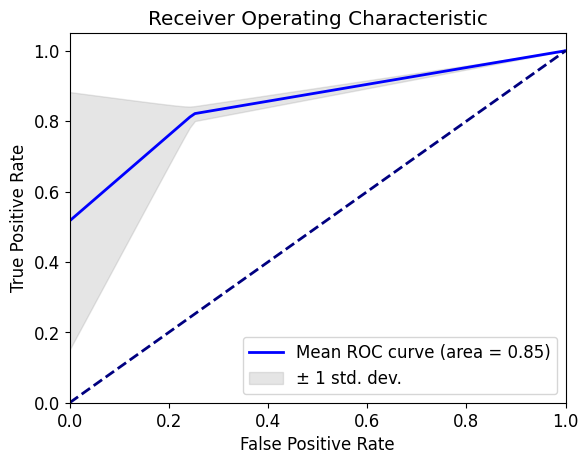

Average accuracy over 3 iterations: 85.19%


In [62]:
# Run the entire process 3 times with different random states
random_states = [2, 99, 10]
all_fprs = []
all_tprs = []
all_aucs = []
accuracies = []

mean_fpr = np.linspace(0, 1, 100)

for i, random_state in enumerate(random_states):
    print(f"Running iteration {i + 1} with random state {random_state}")
    fpr, tpr, roc_auc, accuracy = process_data_and_train_model(random_state)
    all_fprs.append(interp(mean_fpr, fpr, tpr))
    all_tprs.append(tpr)
    all_aucs.append(roc_auc)
    accuracies.append(accuracy)
    print(f"Iteration {i + 1} accuracy: {accuracy:.2f}%")

mean_tpr = np.mean(all_fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_tpr = np.std(all_fprs, axis=0)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label='Mean ROC curve (area = %0.2f)' % mean_auc)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/home/ubuntu/CODON_CVC/CRC_blood/plots/average_ROC_curve_for_public_unique_sequences.png')
plt.show()

print(f"Average accuracy over 3 iterations: {np.mean(accuracies):.2f}%")